In [2]:
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import pickle

from src.models import *
from src.utils import *
from src.utils_data import *
import argparse
import time
import logging
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
graph_type = 'WS'
graph_size = 50
num_unroll = 20

logging.basicConfig(filename='logs/L2G_{}_m{}_x{}.log'.format(graph_type, graph_size, num_unroll),
                    filemode='w',
                    format='%(asctime)s - %(message)s',
                    datefmt='%d-%b-%y %H:%M:%S',
                    level=logging.INFO)

console = logging.StreamHandler()
console.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s | %(message)s', datefmt='%d-%b-%y %H:%M:%S')
console.setFormatter(formatter)
logging.getLogger().addHandler(console)

# data

In [ ]:
# generate synthetic WS graphs

graph_type = 'WS'
edge_type = 'lognormal'
graph_size = 50

graph_hyper = {'k': 5,
               'p': 0.3}

data = generate_WS_parallel(num_samples=8064,
                            num_signals=3000,
                            num_nodes=graph_size,
                            graph_hyper=graph_hyper,
                            weighted=edge_type,
                            weight_scale=True)

with open('data/dataset_{}_{}nodes.pickle'.format(graph_type, graph_size), 'wb') as handle:
    pickle.dump(data, handle, protocol=4)

In [4]:
# load data

batch_size = 32

data_dir = 'data/dataset_{}_{}nodes.pickle'.format(graph_type, graph_size)
train_loader, val_loader, test_loader = data_loading(data_dir, batch_size=batch_size)

loading data at  data/dataset_WS_50nodes.pickle
successfully loading: train 6400, val 1600, test 64, batch 32


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

for _, W in test_loader:
    eg = torch_sqaureform_to_matrix(W, device='cpu')

plt.figure()
sns.heatmap(eg[4])
plt.show()

<Figure size 640x480 with 2 Axes>

# Training

In [6]:
num_unroll = 20
graph_size = 50
n_hid = 32
n_latent = 16
n_nodeFeat = 1
n_graphFeat = 16

lr = 1e-02
lr_decay = 0.95

net = learn2graph(num_unroll, graph_size, n_hid,
                  n_latent, n_nodeFeat, n_graphFeat).to(device)

optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, lr_decay)

logging.info(net)

03-Jun-21 11:54:46 | learn2graph(
  (vae): TopoDiffVAE(
    (enc): GraphEnc(
      (conv1): GraphConvLayer()
      (conv2): GraphConvLayer()
      (fc1): Linear(in_features=64, out_features=32, bias=True)
      (fc2): Linear(in_features=32, out_features=16, bias=True)
    )
    (f_mean): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
    )
    (f_var): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
    )
    (dec): Sequential(
      (0): Linear(in_features=1241, out_features=1633, bias=True)
      (1): Tanh()
      (2): Linear(in_features=1633, out_features=1225, bias=True)
    )
  )
)


In [7]:
# Training:
n_epochs = 300

dur = []

epoch_train_gmse = []
epoch_val_gmse = []

for epoch in range(n_epochs):

    train_unrolling_loss, train_vae_loss, train_kl_loss, train_gmse, val_gmse = [], [], [], [], []

    t0 = time.time()

    net.train()
    for z, w_gt_batch in train_loader:
        z = z.to(device)
        w_gt_batch = w_gt_batch.to(device)
        this_batch_size = w_gt_batch.size()[0]

        optimizer.zero_grad()
        w_list, vae_loss, vae_kl, _ = net.forward(z, w_gt_batch, threshold=1e-04, kl_hyper=1)

        unrolling_loss = torch.mean(
            torch.stack([acc_loss(w_list[i, :, :], w_gt_batch[i, :], dn=0.9) for i in range(batch_size)])
        )

        loss = unrolling_loss + vae_loss
        loss.backward()
        optimizer.step()

        w_pred = w_list[:, num_unroll - 1, :]
        gmse = gmse_loss_batch_mean(w_pred, w_gt_batch)

        train_gmse.append(gmse.item())
        train_unrolling_loss.append(unrolling_loss.item())
        train_vae_loss.append(vae_loss.item())
        train_kl_loss.append(vae_kl.item())

    scheduler.step()

    net.eval()
    for z, w_gt_batch in val_loader:
        z = z.to(device)
        w_gt_batch = w_gt_batch.to(device)

        w_list = net.validation(z, threshold=1e-04)
        w_pred = torch.clamp(w_list[:, num_unroll - 1, :], min=0)
        loss = gmse_loss_batch_mean(w_pred, w_gt_batch)
        val_gmse.append(loss.item())

    dur.append(time.time() - t0)

    logging.info("Epoch {:04d} | lr: {:04.8f} | Time(s): {:.4f}".format(epoch + 1, scheduler.get_lr()[0], np.mean(dur)))
    logging.info("== train Loss <unroll: {:04.4f} | vae : {:04.4f} | kl : {:04.4f}>".format(np.mean(train_unrolling_loss),
                                                                                  np.mean(train_vae_loss),
                                                                                  np.mean(train_kl_loss)))
    logging.info("== gmse <train: {:04.4f} | val: {:04.4f}> ".format(np.mean(train_gmse), np.mean(val_gmse)))

    epoch_train_gmse.append(np.mean(train_gmse))
    epoch_val_gmse.append(np.mean(val_gmse))

03-Jun-21 11:55:31 | Epoch 0001 | lr: 0.00902500 | Time(s): 40.8966
03-Jun-21 11:55:31 | == train Loss <unroll: 431.1791 | vae : 17433609.2710 | kl : 17430613.8530>
03-Jun-21 11:55:31 | == gmse <train: 473.5473 | val: 0.4936> 
03-Jun-21 11:56:12 | Epoch 0002 | lr: 0.00857375 | Time(s): 40.7864
03-Jun-21 11:56:12 | == train Loss <unroll: 4.6488 | vae : 3.0605 | kl : 0.0197>
03-Jun-21 11:56:12 | == gmse <train: 0.5693 | val: 0.5447> 
03-Jun-21 11:56:53 | Epoch 0003 | lr: 0.00814506 | Time(s): 40.8395
03-Jun-21 11:56:53 | == train Loss <unroll: 4.5149 | vae : 3.5714 | kl : 0.0193>
03-Jun-21 11:56:53 | == gmse <train: 0.6749 | val: 0.6758> 
03-Jun-21 11:57:33 | Epoch 0004 | lr: 0.00773781 | Time(s): 40.8260
03-Jun-21 11:57:33 | == train Loss <unroll: 4.4031 | vae : 4.1391 | kl : 0.0190>
03-Jun-21 11:57:33 | == gmse <train: 0.7915 | val: 0.7207> 
03-Jun-21 11:58:14 | Epoch 0005 | lr: 0.00735092 | Time(s): 40.8396
03-Jun-21 11:58:14 | == train Loss <unroll: 4.4537 | vae : 5.2931 | kl : 0.018

03-Jun-21 12:23:21 | Epoch 0042 | lr: 0.00110183 | Time(s): 40.7423
03-Jun-21 12:23:21 | == train Loss <unroll: 1.8833 | vae : 5.8874 | kl : 0.0066>
03-Jun-21 12:23:21 | == gmse <train: 0.9290 | val: 0.7351> 
03-Jun-21 12:24:02 | Epoch 0043 | lr: 0.00104674 | Time(s): 40.7440
03-Jun-21 12:24:02 | == train Loss <unroll: 1.8305 | vae : 5.6151 | kl : 0.0065>
03-Jun-21 12:24:02 | == gmse <train: 0.8821 | val: 0.6594> 
03-Jun-21 12:24:43 | Epoch 0044 | lr: 0.00099440 | Time(s): 40.7363
03-Jun-21 12:24:43 | == train Loss <unroll: 1.7904 | vae : 5.4278 | kl : 0.0064>
03-Jun-21 12:24:43 | == gmse <train: 0.8490 | val: 0.6496> 
03-Jun-21 12:25:24 | Epoch 0045 | lr: 0.00094468 | Time(s): 40.7447
03-Jun-21 12:25:24 | == train Loss <unroll: 1.7514 | vae : 5.2409 | kl : 0.0063>
03-Jun-21 12:25:24 | == gmse <train: 0.8161 | val: 0.6713> 
03-Jun-21 12:26:04 | Epoch 0046 | lr: 0.00089745 | Time(s): 40.7434
03-Jun-21 12:26:04 | == train Loss <unroll: 1.7093 | vae : 5.0235 | kl : 0.0061>
03-Jun-21 12:26

03-Jun-21 12:49:40 | == train Loss <unroll: 0.9957 | vae : 2.7075 | kl : 0.0018>
03-Jun-21 12:49:40 | == gmse <train: 0.2986 | val: 0.2879> 
03-Jun-21 12:50:20 | Epoch 0082 | lr: 0.00014160 | Time(s): 40.6075
03-Jun-21 12:50:20 | == train Loss <unroll: 0.9875 | vae : 2.6799 | kl : 0.0017>
03-Jun-21 12:50:20 | == gmse <train: 0.2903 | val: 0.2789> 
03-Jun-21 12:51:01 | Epoch 0083 | lr: 0.00013452 | Time(s): 40.6054
03-Jun-21 12:51:01 | == train Loss <unroll: 0.9803 | vae : 2.6609 | kl : 0.0016>
03-Jun-21 12:51:01 | == gmse <train: 0.2828 | val: 0.2702> 
03-Jun-21 12:51:41 | Epoch 0084 | lr: 0.00012779 | Time(s): 40.6052
03-Jun-21 12:51:41 | == train Loss <unroll: 0.9738 | vae : 2.6468 | kl : 0.0015>
03-Jun-21 12:51:41 | == gmse <train: 0.2758 | val: 0.2641> 
03-Jun-21 12:52:22 | Epoch 0085 | lr: 0.00012140 | Time(s): 40.6047
03-Jun-21 12:52:22 | == train Loss <unroll: 0.9666 | vae : 2.6292 | kl : 0.0014>
03-Jun-21 12:52:22 | == gmse <train: 0.2685 | val: 0.2600> 
03-Jun-21 12:53:02 | Ep

03-Jun-21 13:15:55 | == gmse <train: 0.0878 | val: 0.0845> 
03-Jun-21 13:16:35 | Epoch 0121 | lr: 0.00001915 | Time(s): 40.5334
03-Jun-21 13:16:35 | == train Loss <unroll: 0.7903 | vae : 2.3248 | kl : 0.0000>
03-Jun-21 13:16:35 | == gmse <train: 0.0861 | val: 0.0819> 
03-Jun-21 13:17:15 | Epoch 0122 | lr: 0.00001820 | Time(s): 40.5313
03-Jun-21 13:17:15 | == train Loss <unroll: 0.7887 | vae : 2.3191 | kl : 0.0000>
03-Jun-21 13:17:15 | == gmse <train: 0.0846 | val: 0.0818> 
03-Jun-21 13:17:56 | Epoch 0123 | lr: 0.00001729 | Time(s): 40.5315
03-Jun-21 13:17:56 | == train Loss <unroll: 0.7872 | vae : 2.3158 | kl : 0.0000>
03-Jun-21 13:17:56 | == gmse <train: 0.0832 | val: 0.0798> 
03-Jun-21 13:18:36 | Epoch 0124 | lr: 0.00001642 | Time(s): 40.5300
03-Jun-21 13:18:36 | == train Loss <unroll: 0.7859 | vae : 2.3133 | kl : 0.0000>
03-Jun-21 13:18:36 | == gmse <train: 0.0819 | val: 0.0784> 
03-Jun-21 13:19:17 | Epoch 0125 | lr: 0.00001560 | Time(s): 40.5289
03-Jun-21 13:19:17 | == train Loss <

03-Jun-21 13:42:49 | Epoch 0160 | lr: 0.00000259 | Time(s): 40.4885
03-Jun-21 13:42:49 | == train Loss <unroll: 0.7727 | vae : 2.2484 | kl : 0.0000>
03-Jun-21 13:42:49 | == gmse <train: 0.0700 | val: 0.0647> 
03-Jun-21 13:43:29 | Epoch 0161 | lr: 0.00000246 | Time(s): 40.4863
03-Jun-21 13:43:29 | == train Loss <unroll: 0.7726 | vae : 2.2477 | kl : 0.0000>
03-Jun-21 13:43:29 | == gmse <train: 0.0700 | val: 0.0648> 
03-Jun-21 13:44:09 | Epoch 0162 | lr: 0.00000234 | Time(s): 40.4862
03-Jun-21 13:44:09 | == train Loss <unroll: 0.7726 | vae : 2.2468 | kl : 0.0000>
03-Jun-21 13:44:09 | == gmse <train: 0.0700 | val: 0.0645> 
03-Jun-21 13:44:50 | Epoch 0163 | lr: 0.00000222 | Time(s): 40.4866
03-Jun-21 13:44:50 | == train Loss <unroll: 0.7725 | vae : 2.2462 | kl : 0.0000>
03-Jun-21 13:44:50 | == gmse <train: 0.0699 | val: 0.0645> 
03-Jun-21 13:45:30 | Epoch 0164 | lr: 0.00000211 | Time(s): 40.4833
03-Jun-21 13:45:30 | == train Loss <unroll: 0.7724 | vae : 2.2456 | kl : 0.0000>
03-Jun-21 13:45

03-Jun-21 14:09:01 | == train Loss <unroll: 0.7706 | vae : 2.2341 | kl : 0.0000>
03-Jun-21 14:09:01 | == gmse <train: 0.0682 | val: 0.0612> 
03-Jun-21 14:09:42 | Epoch 0200 | lr: 0.00000033 | Time(s): 40.4540
03-Jun-21 14:09:42 | == train Loss <unroll: 0.7706 | vae : 2.2339 | kl : 0.0000>
03-Jun-21 14:09:42 | == gmse <train: 0.0681 | val: 0.0611> 
03-Jun-21 14:10:22 | Epoch 0201 | lr: 0.00000032 | Time(s): 40.4559
03-Jun-21 14:10:22 | == train Loss <unroll: 0.7706 | vae : 2.2338 | kl : 0.0000>
03-Jun-21 14:10:22 | == gmse <train: 0.0681 | val: 0.0612> 
03-Jun-21 14:11:03 | Epoch 0202 | lr: 0.00000030 | Time(s): 40.4561
03-Jun-21 14:11:03 | == train Loss <unroll: 0.7706 | vae : 2.2337 | kl : 0.0000>
03-Jun-21 14:11:03 | == gmse <train: 0.0681 | val: 0.0612> 
03-Jun-21 14:11:43 | Epoch 0203 | lr: 0.00000029 | Time(s): 40.4563
03-Jun-21 14:11:43 | == train Loss <unroll: 0.7706 | vae : 2.2336 | kl : 0.0000>
03-Jun-21 14:11:43 | == gmse <train: 0.0681 | val: 0.0611> 
03-Jun-21 14:12:24 | Ep

03-Jun-21 14:35:13 | == gmse <train: 0.0680 | val: 0.0610> 
03-Jun-21 14:35:53 | Epoch 0239 | lr: 0.00000005 | Time(s): 40.4280
03-Jun-21 14:35:53 | == train Loss <unroll: 0.7705 | vae : 2.2316 | kl : 0.0000>
03-Jun-21 14:35:53 | == gmse <train: 0.0680 | val: 0.0610> 
03-Jun-21 14:36:34 | Epoch 0240 | lr: 0.00000004 | Time(s): 40.4290
03-Jun-21 14:36:34 | == train Loss <unroll: 0.7705 | vae : 2.2316 | kl : 0.0000>
03-Jun-21 14:36:34 | == gmse <train: 0.0680 | val: 0.0610> 
03-Jun-21 14:37:14 | Epoch 0241 | lr: 0.00000004 | Time(s): 40.4287
03-Jun-21 14:37:14 | == train Loss <unroll: 0.7705 | vae : 2.2316 | kl : 0.0000>
03-Jun-21 14:37:14 | == gmse <train: 0.0680 | val: 0.0611> 
03-Jun-21 14:37:55 | Epoch 0242 | lr: 0.00000004 | Time(s): 40.4288
03-Jun-21 14:37:55 | == train Loss <unroll: 0.7705 | vae : 2.2316 | kl : 0.0000>
03-Jun-21 14:37:55 | == gmse <train: 0.0680 | val: 0.0611> 
03-Jun-21 14:38:35 | Epoch 0243 | lr: 0.00000004 | Time(s): 40.4273
03-Jun-21 14:38:35 | == train Loss <

03-Jun-21 15:00:33 | Epoch 0278 | lr: 0.00000001 | Time(s): 40.0801
03-Jun-21 15:00:33 | == train Loss <unroll: 0.7705 | vae : 2.2313 | kl : 0.0000>
03-Jun-21 15:00:33 | == gmse <train: 0.0680 | val: 0.0610> 
03-Jun-21 15:01:09 | Epoch 0279 | lr: 0.00000001 | Time(s): 40.0662
03-Jun-21 15:01:09 | == train Loss <unroll: 0.7705 | vae : 2.2312 | kl : 0.0000>
03-Jun-21 15:01:09 | == gmse <train: 0.0680 | val: 0.0610> 
03-Jun-21 15:01:46 | Epoch 0280 | lr: 0.00000001 | Time(s): 40.0523
03-Jun-21 15:01:46 | == train Loss <unroll: 0.7705 | vae : 2.2312 | kl : 0.0000>
03-Jun-21 15:01:46 | == gmse <train: 0.0680 | val: 0.0610> 
03-Jun-21 15:02:22 | Epoch 0281 | lr: 0.00000001 | Time(s): 40.0381
03-Jun-21 15:02:22 | == train Loss <unroll: 0.7705 | vae : 2.2312 | kl : 0.0000>
03-Jun-21 15:02:22 | == gmse <train: 0.0680 | val: 0.0610> 
03-Jun-21 15:02:58 | Epoch 0282 | lr: 0.00000000 | Time(s): 40.0255
03-Jun-21 15:02:58 | == train Loss <unroll: 0.7705 | vae : 2.2312 | kl : 0.0000>
03-Jun-21 15:02

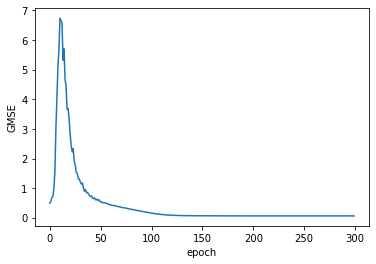

In [16]:
# validation loss:

import matplotlib.pyplot as plt
plt.figure()
plt.plot(epoch_val_gmse)
plt.ylabel('GMSE')
plt.xlabel('epoch')
plt.show()

In [18]:
# save trained model

save_path = 'saved_model/L2G_{}{}_unroll{}.pt'.format(graph_type,
                                                      graph_size,
                                                      num_unroll)

torch.save({'net_state_dict': net.state_dict(),
            'optimiser_state_dict': optimizer.state_dict()
            }, save_path)


logging.info('model saved at: {}'.format(save_path))

03-Jun-21 15:17:55 | model saved at: saved_model/L2G_WS50_unroll20.pt


# Test / Inference

In [52]:

for z, w_gt_batch in test_loader:
    test_loss = []

    z = z.to(device)
    w_gt_batch = w_gt_batch.to(device)
    this_batch_size = w_gt_batch.size()[0]

    adj_batch = w_gt_batch.clone()
    adj_batch[adj_batch > 0] = 1

    w_list = net.validation(z, threshold=1e-04)
    w_pred = torch.clamp(w_list[:, num_unroll - 1, :], min=0)

    loss_mean = gmse_loss_batch_mean(w_pred, w_gt_batch)
    loss_pred = gmse_loss_batch(w_pred, w_gt_batch)

    layer_loss_batch = torch.stack([layerwise_gmse_loss(w_list[i, :, :], w_gt_batch[i, :]) for i in range(batch_size)])


loss_all_data = loss_pred.detach().cpu().numpy()
final_pred_loss, final_pred_loss_ci, _, _ = mean_confidence_interval(loss_all_data, 0.95)
logging.info('GMSE: {} +- {}'.format(final_pred_loss, final_pred_loss_ci))

aps_auc = binary_metrics_batch(adj_batch, w_pred, device)
logging.info('aps: {} +- {}'.format(aps_auc['aps_mean'], aps_auc['aps_ci']))
logging.info('auc: {} +- {}'.format(aps_auc['auc_mean'], aps_auc['auc_ci']))

layer_loss_mean = [mean_confidence_interval(layer_loss_batch[:,i].detach().cpu().numpy(), confidence=0.95)[0] for i in range(num_unroll)]
layer_loss_mean_ci = [mean_confidence_interval(layer_loss_batch[:,i].detach().cpu().numpy(), confidence=0.95)[1] for i in range(num_unroll)]
logging.info('layerwise test loss :{}'.format(layer_loss_mean))

03-Jun-21 15:27:55 | GMSE: 0.05936715006828308 +- 0.0038578716206355414
03-Jun-21 15:27:55 | aps: 0.9960138205245266 +- 0.0011615028706712285
03-Jun-21 15:27:55 | auc: 0.9988567361111111 +- 0.0005779778762602031
03-Jun-21 15:27:55 | layerwise test loss :[1.0435071, 0.75211203, 0.2969693, 0.29407477, 0.19469345, 0.14014131, 0.06299843, 0.07452516, 0.056948557, 0.0628472, 0.05281911, 0.058609165, 0.05863236, 0.048517235, 0.0485345, 0.048531204, 0.04853106, 0.048537016, 0.048606172, 0.066911146]


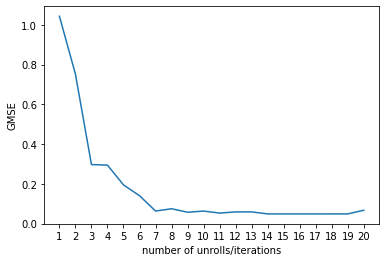

In [53]:
plt.figure()
plt.plot(np.arange(1,21,1), layer_loss_mean)
plt.xticks(np.arange(1,21,1))
plt.ylabel('GMSE')
plt.xlabel('number of unrolls/iterations')
plt.show()

In [54]:
result = {
    'epoch_train_gmse': epoch_train_gmse,
    'epoch_val_gmse': epoch_train_gmse,
    'pred_gmse_mean': final_pred_loss,
    'pred_gmse_mean_ci': final_pred_loss_ci,
    'auc_mean': aps_auc['auc_mean'],
    'auc_ci': aps_auc['auc_ci'],
    'aps_mean': aps_auc['aps_mean'],
    'aps_ci': aps_auc['aps_ci'],
    'layerwise_gmse_mean': layer_loss_mean,
    'layerwise_gmse_mean_ci ': layer_loss_mean_ci
}


result_path = 'saved_results/L2G_{}{}_unroll{}.pt'.format(graph_type,
                                                          graph_size,
                                                          num_unroll)


with open(result_path, 'wb') as handle:
    pickle.dump(result, handle, protocol=4)

logging.info('results saved at: {}'.format(result_path))

03-Jun-21 15:27:59 | results saved at: saved_results/L2G_WS50_unroll20.pt


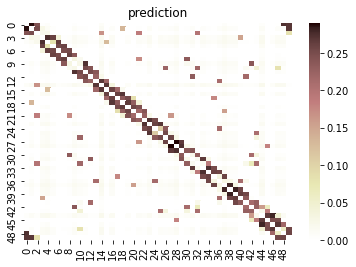

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import squareform
idx = 10
plt.figure()
sns.heatmap(squareform(w_pred[idx,:].detach().cpu().numpy()), cmap = 'pink_r')
plt.title('prediction')
plt.show()

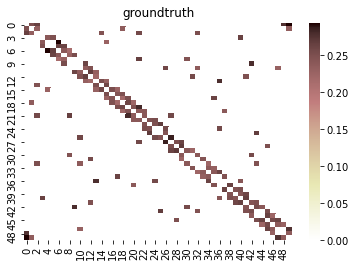

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import squareform

plt.figure()
sns.heatmap(squareform(w_gt_batch[idx,:].detach().cpu().numpy()), cmap = 'pink_r')
plt.title('groundtruth')
plt.show()